<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: fine-tuning

In the previous notebook we covered feature extraction. Now let's learn fine-tuning.

In [3]:
!nvidia-smi

Wed Oct 18 06:54:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've created some helper functions. However, this is tedious, so let's import them all at once

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-18 06:54:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-18 06:54:40 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, create_tensorboard_callback

## Getting data

Using pretrained models contained within TensorFlow, specifically `tf.keras.applications`

In [6]:
# get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip the data
unzip_data("10_food_classes_10_percent.zip")
#walk through directory - check out how many subdirectories and images there are
walk_through_dir("10_food_classes_10_percent/")

--2023-10-18 06:54:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.207, 173.194.206.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   206MB/s    in 0.8s    

2023-10-18 06:54:44 (206 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images

In [7]:
# Create the training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

Previously we used ImageDataGenerator class. This is the vanilla TensorFlow way.

However, there's a new faster way `tf.keras.utils.image_dataset_from_directory`

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode="categorical",
                                                                    batch_size=BATCH_SIZE) #default so not needed
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Keras Sequential API - define layers one by one

Keras Functional API - define the following layer as a function into which the previous layer output goes as input

## Model 0: Building a transfer learning model using the Keras Functional API

Functional API is more flexible

In [10]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model layers
base_model.trainable = False

# 3. Create inputs to our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (optional for EfficientNetB0. If using other models, this strep is necessary) normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model in order to aggregate most important information and reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling 2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names),
                                activation="softmax",
                                name="output_layer")(x)

# 8. Compine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # validating for a quarter of data in order to fit quicker
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_0")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20231018-065453
Epoch 1/5
24/24 [==============================] - 20s 263ms/step - loss: 1.8634 - accuracy: 0.4053 - val_loss: 1.2928 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 4s 146ms/step - loss: 1.0988 - accuracy: 0.7613 - val_loss: 0.8759 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 6s 212ms/step - loss: 0.7998 - accuracy: 0.8213 - val_loss: 0.7002 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 4s 142ms/step - loss: 0.6416 - accuracy: 0.8560 - val_loss: 0.6058 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 4s 142ms/step - loss: 0.5515 - accuracy: 0.8787 - val_loss: 0.5566 - val_accuracy: 0.8651


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5526 - accuracy: 0.8656


[0.5526129603385925, 0.8655999898910522]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
# Get the summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [14]:
# Summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

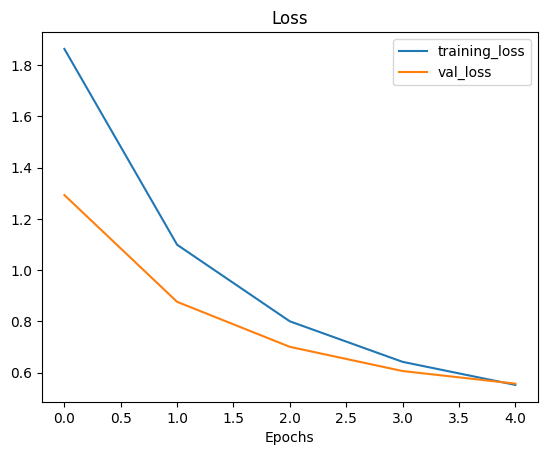

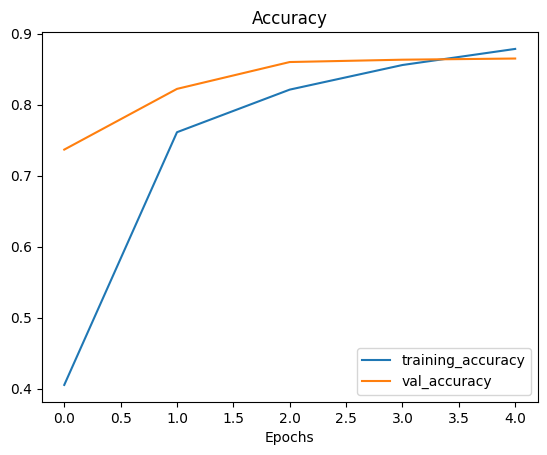

In [15]:
# Check out the model's training curves
plot_loss_curves(history_0)

## Running a series of experiments

1. Feature extraction model with 1% of the training data with data augmentation
2. Feature extraction with 10% of the data and augmantation
3. Fine-tuning on 10% of the training data with data augmentation
4. Fine tuning with 100% of the training data

### Experiment 1: Feature extraction, 1% of the data, augmented

#### Loading and preprocessing data

In [16]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-10-18 06:55:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 142.250.103.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   243MB/s    in 0.5s    

2023-10-18 06:55:48 (243 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [17]:
# Create train and test dirs
train_dir_1 = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [18]:
# How many images are there
walk_through_dir("10_food_classes_1_percent/")

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There 

In [19]:
# Set up data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1,
                                                                   label_mode="categorical",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Augmenting the data
Data augmentation is implemented at the level of a layer in our model
* `tf.keras.layers.experimental.preprocessing.()`

The preprocessing layer is only on during training!?!?!?!?

In [20]:
from tensorflow.keras.layers.experimental import preprocessing
# Create augmentation stage with flips, zooms, rotations etc
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#    preprocessing.Rescale(1./255.)
], name="data_augmentation")

#### Visualize the augmented data

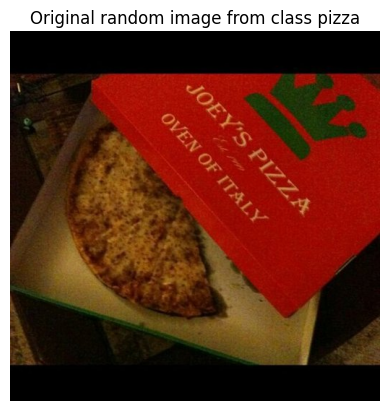

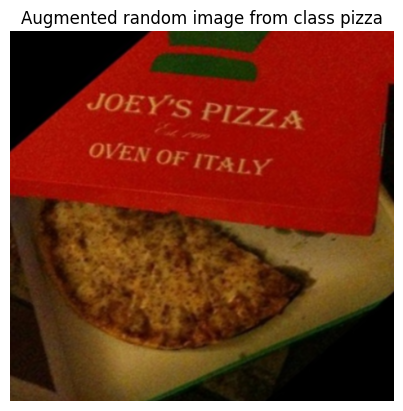

In [29]:
# View a random image before and after augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img/255.)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False);

#### Building the model

In [35]:
# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # removes the output layer as we'll have 10 classes instead of 101000
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add datta augmentation
x = data_augmentation(inputs)

# Pass through the base model
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put a dense layer as output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model out of inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20231018-073714
Epoch 1/5
3/3 [==============================] - 15s 4s/step - loss: 2.3206 - accuracy: 0.1143 - val_loss: 2.3035 - val_accuracy: 0.1283
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1072 - accuracy: 0.2571 - val_loss: 2.2009 - val_accuracy: 0.1694
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8576 - accuracy: 0.4857 - val_loss: 2.0717 - val_accuracy: 0.2763
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7252 - accuracy: 0.6000 - val_loss: 1.9760 - val_accuracy: 0.3207
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5419 - accuracy: 0.6714 - val_loss: 1.8864 - val_accuracy: 0.3832


In [36]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [37]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 1.8927 - accuracy: 0.3692


[1.8927435874938965, 0.3691999912261963]

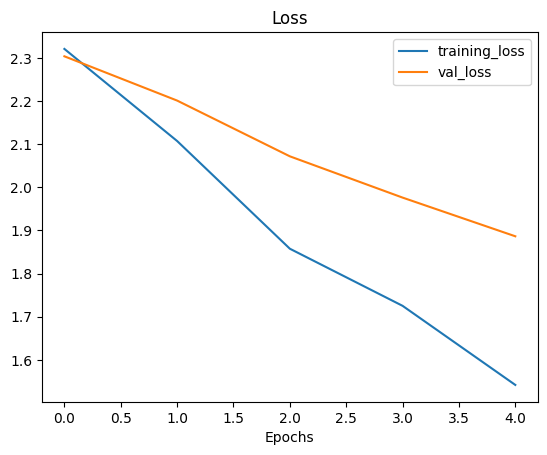

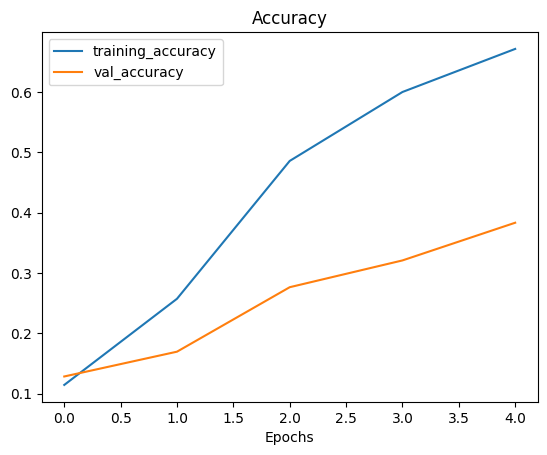

In [38]:
# How does the model do
plot_loss_curves(history_1)

### Experiment 2: Feature extraction, 10% of the data, augmented


In [40]:
# Get 10% of data
train_dir_2 = "10_food_classes_10_percent/train/"
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_2,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [44]:
# Create model 2 with data augmentation in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
    preprocessing.RandomRotation(.2),
    #preprocessing.Rescale(1./255.) # if usign a model different than EfficientNet, rescaling might be necessary
], name="data_augmentation")

# Setup the input shape
input_shape = (224, 224, 3)

# Create a frozen base_model AKA the backbone
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # remember about this

# Create the inputs and outputs
# Define input shape
inputs = layers.Input(shape=input_shape, name="input")

# Run through the augmentation layer
x = data_augmentation(inputs)

# Run through the base model
x = base_model(x, training=False)

# Run through a pooling layer
x = layers.GlobalAveragePooling2D(name="global_pooling_2d")(x)

# Run through a dense layer
outputs = layers.Dense(10, activation="softmax", name="output")(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(optimizer="Adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

#### Creating a ModelCheckpoint callback

The ModelCheckpoint intermediately saves our model or just the weights during training.   

In [45]:
# Set checkpoint path
checkpoint_path = "model_2_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback so that it saves the weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=0)

In [46]:
# Fit the model with the ModelCheckpoint callback
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",experiment_name="model_2")])

Saving TensorBoard log files to: transfer_learning/model_2/20231018-083844
Epoch 1/5
24/24 [==============================] - 27s 724ms/step - loss: 1.9892 - accuracy: 0.3787 - val_loss: 1.4450 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 12s 478ms/step - loss: 1.3086 - accuracy: 0.7200 - val_loss: 0.9701 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 13s 526ms/step - loss: 0.9749 - accuracy: 0.7827 - val_loss: 0.7683 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 12s 492ms/step - loss: 0.8415 - accuracy: 0.7893 - val_loss: 0.6571 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 12s 502ms/step - loss: 0.7407 - accuracy: 0.8200 - val_loss: 0.5889 - val_accuracy: 0.8635
